# POLITECNICO DI MILANO
# PhD Course AI CHALLENGES IN BIOENGINEERING 2025-26
## ECG Challenge: CNN example
---
### Pietro Cerveri

In [2]:
#import libraries

# from google.colab import drive
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import scipy
from scipy.signal import butter, filtfilt, iirnotch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim


from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score,  roc_curve
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Set your own specific drive path
ROOT_PATH   = "/content/drive/My Drive/_DIDATTICA/_POLIMI/AI_Methods_BioEngineering/_2025-2026/04_ECG_Challenge/Source/"
DATA_FOLDER   = os.path.join(ROOT_PATH, "Data/")
DATA_Batch_01 = os.path.join(DATA_FOLDER, "01_batch_ECG_Signals")
DATA_Batch_02 = os.path.join(DATA_FOLDER, "02_batch_ECG_Signals")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#prepare functions for filtering

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=500, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=500, quality_factor=30):
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)

In [5]:
#import the data and filter the signals
# This could be change depending if you download or not the data

filename_Batch_01     = DATA_FOLDER + "VALETUDO_database_1st_batch_en_all_info.xlsx"
filename_Batch_02     = DATA_FOLDER + "VALETUDO_database_2nd_batch_en_all_info.xlsx"
tabular_data_Batch_01 = pd.read_excel(filename_Batch_01)
tabular_data_Batch_02 = pd.read_excel(filename_Batch_02)

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(DATA_Batch_01) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(DATA_Batch_02) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))
signals_2 = np.empty((len(ECGs_2), 5000, 12))

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(DATA_Batch_01, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_1[index, :, :] = ecg

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(DATA_Batch_02, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg

# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data_Batch_01.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_Batch_02.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)



Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 19)


In [6]:
print(f"nb pos: {np.sum(tabular_data['sport_ability']==1)}")
print(f"% pos: {np.sum(tabular_data['sport_ability']==1)/len(tabular_data['sport_ability'])*100:.2f}%")

nb pos: 360
% pos: 68.44%


In [7]:
#function to extract segment

def segment_ecg(signal, tabular_data, segment_length=2500):

    segments = np.zeros((signal.shape[0], segment_length, signal.shape[2]))
    index = 0
    for i in range(signal.shape[0]):

      start = 0 # we take the start at the middle or elsewhere
      end = start + segment_length
      segments[index, :, :] = signal[i, start:end, :]
      index += 1

    return segments, tabular_data

In [8]:
#prepare the class for the dataset without data augmentation

class ECGDataset(Dataset):
    def __init__(self, tabular, signals, labels):
        self.signals = torch.tensor(signals, dtype=torch.float32).permute(0, 2, 1)
        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)
        self.tabular = torch.tensor(tabular.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tabular[idx], self.signals[idx], self.labels[idx]

In [11]:
# architecture of the three branches model
# In this CNN we have 3 branches one for the 6 first leads (crop in segments of 2500), one for the 6 other lead in the same format and one branch for the tabular data (6 features)


class ThreeBranchGRUModel(nn.Module):
    def __init__(self, hidden_size=64, num_layers=1):
        super(ThreeBranchGRUModel, self).__init__()

        self.fc1_tabular = nn.Linear(6, 16)
        self.fc2_tabular = nn.Linear(16, 32)

        self.conv1_1 = nn.Conv1d(in_channels=6, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv2_1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv1_2 = nn.Conv1d(in_channels=6, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv2_2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.gru_signal = nn.GRU(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.fc1_final = nn.Linear(hidden_size * 2 + 32, 128)
        self.fc2_final = nn.Linear(128, 1)

    def forward(self, tab, sig):
        #print(f"tab input shape: {tab.shape}, sig input shape: {sig.shape}")
        x_tabular = F.gelu(self.fc1_tabular(tab))
        #print(f"x_tabular shape after the first layer: {x_tabular.shape}")
        x_tabular = self.fc2_tabular(x_tabular)
        #print(f"x_tabular shape after the first layer: {x_tabular.shape}")

        sig1 = sig[:, :6, :]
        #print(f"sig1 input shape: {sig1.shape}")
        sig1 = self.pool(F.gelu(self.conv1_1(sig1)))
        #print(f"sig1 shape after the first layer: {sig1.shape}")
        sig1 = self.pool(F.gelu(self.conv2_1(sig1)))
        #print(f"sig1 shape after the second layer: {sig1.shape}")
        sig1 = sig1.permute(0, 2, 1)
        _, x_sig1 = self.gru_signal(sig1)
        #print(f"x_sig1 shape: {x_sig1.shape}")

        sig2 = sig[:, 6:, :]
        #print(f"sig2 input shape: {sig2.shape}")
        sig2 = self.pool(F.gelu(self.conv1_2(sig2)))
        #print(f"sig2 shape after the first layer: {sig2.shape}")
        sig2 = self.pool(F.gelu(self.conv2_2(sig2)))
        #print(f"sig2 shape after the second layer: {sig2.shape}")
        sig2 = sig2.permute(0, 2, 1)
        _, x_sig2 = self.gru_signal(sig2)
        #print(f"x_sig2 shape: {x_sig2.shape}")

        x = torch.cat((x_sig1[-1], x_sig2[-1]), dim=1)
        #print(f"x shape after branches concatenation: {x.shape}")
        x = torch.cat((x, x_tabular), dim=1)
        #print(f"x shape after tabular concatenation: {x.shape}")
        x = F.gelu(self.fc1_final(x))
        #print(f"x shape after final processing: {x.shape}")
        x = torch.sigmoid(self.fc2_final(x))
        #print(f"output shape: {x.shape}")
        return x


In [12]:
#implementation of the ten fold cross-validation

strat_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_list_all_folds = []
f1_list_all_folds_train = []
sensitivity_list_all_folds = []
sensitivity_list_all_folds_train = []
specificity_list_all_folds = []
specificity_list_all_folds_train = []
accuracy_list_all_folds = []
accuracy_list_all_folds_train = []
auc_score_list_all_folds = []
auc_score_list_all_folds_train = []
fpr_list_all_folds = []
tpr_list_all_folds = []
test_loss_all_folds = []
train_loss_all_folds = []
epochs_all_fold = []
train_loss_max = []
test_loss_max = []

num_epocs = 5 #num_epocs = 50

for train_index, test_index in strat_kf.split(tabular_data, tabular_data['sport_ability']):
    X_train, X_test = tabular_data.iloc[train_index,:], tabular_data.iloc[test_index,:]
    ecg_train = signals[train_index,:,:]
    ecg_test = signals[test_index,:,:]

    ecg_train_segments, tabular_train_expand = segment_ecg(ecg_train, X_train)
    ecg_test_segments, tabular_test_expand = segment_ecg(ecg_test, X_test)

    Y_train = tabular_train_expand['sport_ability']
    Y_test = tabular_test_expand['sport_ability']

    X_train_final = tabular_train_expand.drop(columns=['sport_ability', 'ECG_patient_id'])
    X_test_final = tabular_test_expand.drop(columns=['sport_ability', 'ECG_patient_id'])

    X_train_final['age_at_exam'] = X_train_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_train_final['trainning_load'] = X_train_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    imputer = IterativeImputer()
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)

    categorical_cols = ['sex', 'sport_classification']
    numeric_cols = ['age_at_exam', 'height', 'weight', 'trainning_load']

    X_test_final['age_at_exam'] = X_test_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_test_final['trainning_load'] = X_test_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    X_test_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

    scaler = StandardScaler()
    X_train_imputed[numeric_cols] = scaler.fit_transform(X_train_imputed[numeric_cols])
    X_test_imputed[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])

    for col in categorical_cols:
        X_train_imputed[col] = X_train_imputed[col].apply(lambda x: -1 if x == 0 else x)
        X_test_imputed[col] = X_test_imputed[col].apply(lambda x: -1 if x == 0 else x)

    train_final_df = pd.concat([X_train_imputed[numeric_cols], X_train_imputed[categorical_cols]], axis=1)
    test_final_df = pd.concat([X_test_imputed[numeric_cols], X_test_imputed[categorical_cols]], axis=1)

    train_dataset = ECGDataset(train_final_df, ecg_train_segments, Y_train)
    test_dataset = ECGDataset(test_final_df, ecg_test_segments, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = ThreeBranchGRUModel().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    f1_list_single_fold = []
    f1_list_single_fold_train = []
    sensitivity_list_single_fold = []
    sensitivity_list_single_fold_train = []
    specificity_list_single_fold = []
    specificity_list_single_fold_train = []
    accuracy_list_single_fold = []
    accuracy_list_single_fold_train = []
    auc_score_list_single_fold = []
    auc_score_list_single_fold_train = []
    fpr_list_single_fold = []
    tpr_list_single_fold = []
    train_loss_single_fold = []
    test_loss_single_fold = []
    epochs_single_fold = []

    for epoch in tqdm(range(num_epocs)):

        train_loss = 0
        correct = 0

        all_labels = []
        all_preds = []
        all_outputs = []

        for tabular, signals_ecg, labels in train_loader:
            model.train()
            tabular, signals_ecg, labels = tabular.to(device), signals_ecg.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(tabular, signals_ecg)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (outputs > 0.6).int()
            labels = labels.int()
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu())
            all_preds.extend(predicted.cpu())
            all_outputs.extend(outputs.cpu())

        print('\n')
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

        train_loss_single_fold.append(train_loss/len(train_loader))
        train_accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        auc_score = roc_auc_score(all_labels, all_preds)

        f1_list_single_fold_train.append(f1)
        sensitivity_list_single_fold_train.append(sensitivity)
        specificity_list_single_fold_train.append(specificity)
        accuracy_list_single_fold_train.append(train_accuracy)
        auc_score_list_single_fold_train.append(auc_score)

        model.eval()

        all_labels = []
        all_preds = []
        all_outputs = []

        with torch.no_grad():

            correct = 0
            test_loss = 0

            for tabular, signals_ecg, labels in test_loader:

                tabular, signals_ecg, labels = tabular.to(device), signals_ecg.to(device), labels.to(device)
                outputs = model(tabular, signals_ecg)
                loss = criterion(outputs.squeeze(), labels.squeeze())
                test_loss += loss.item()
                predicted = (outputs.squeeze() > 0.6).int()
                labels = labels.squeeze().int()
                correct += (predicted.squeeze() == labels).sum().item()
                all_labels.extend(labels.cpu())
                all_preds.extend(predicted.cpu())
                all_outputs.extend(outputs.squeeze().cpu())

            test_loss /= len(test_loader)

            test_loss_single_fold.append(test_loss)
            test_accuracy = accuracy_score(all_labels, all_preds) * 100
            f1 = f1_score(all_labels, all_preds)
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(all_labels, all_preds)

            f1_list_single_fold.append(f1)
            sensitivity_list_single_fold.append(sensitivity)
            specificity_list_single_fold.append(specificity)
            accuracy_list_single_fold.append(test_accuracy)
            auc_score_list_single_fold.append(auc_score)
            fpr, tpr, _ = roc_curve(all_labels, all_outputs)
            fpr_list_single_fold.append(fpr)
            tpr_list_single_fold.append(tpr)
            epochs_single_fold.append(epoch)

            print(f"Test loss: {test_loss}, Accuracy: {test_accuracy:.2f}%", f"F1 Score: {f1:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, AUC: {auc_score:.4f}")
            print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    max_f1 = max(f1_list_single_fold)
    max_f1_index = f1_list_single_fold.index(max_f1)

    f1_list_all_folds.append(f1_list_single_fold[max_f1_index])
    f1_list_all_folds_train.append(f1_list_single_fold_train[max_f1_index])
    sensitivity_list_all_folds.append(sensitivity_list_single_fold[max_f1_index])
    sensitivity_list_all_folds_train.append(sensitivity_list_single_fold_train[max_f1_index])
    specificity_list_all_folds.append(specificity_list_single_fold[max_f1_index])
    specificity_list_all_folds_train.append(specificity_list_single_fold_train[max_f1_index])
    accuracy_list_all_folds.append(accuracy_list_single_fold[max_f1_index])
    accuracy_list_all_folds_train.append(accuracy_list_single_fold_train[max_f1_index])
    auc_score_list_all_folds.append(auc_score_list_single_fold[max_f1_index])
    auc_score_list_all_folds_train.append(auc_score_list_single_fold_train[max_f1_index])
    fpr_list_all_folds.append(fpr_list_single_fold[max_f1_index])
    tpr_list_all_folds.append(tpr_list_single_fold[max_f1_index])
    test_loss_all_folds.append(test_loss_single_fold)
    test_loss_max.append(test_loss_single_fold[max_f1_index])
    train_loss_all_folds.append(train_loss_single_fold)
    train_loss_max.append(train_loss_single_fold[max_f1_index])
    epochs_all_fold.append(epochs_single_fold[max_f1_index])



print(f"Accuracy: {accuracy_list_all_folds}")
print(f"Accuracy Train: {accuracy_list_all_folds_train}")
print(f"F1 Score: {f1_list_all_folds}")
print(f"F1 Score Train: {f1_list_all_folds_train}")
print(f"Sensitivity: {sensitivity_list_all_folds}")
print(f"Sensitivity Train: {sensitivity_list_all_folds_train}")
print(f"Specificity: {specificity_list_all_folds}")
print(f"Specificity Train: {specificity_list_all_folds_train}")
print(f"AUC: {auc_score_list_all_folds}")
print(f"AUC Train: {auc_score_list_all_folds_train}")
print(f"Test Loss: {test_loss_max}")
print(f"Train Loss: {train_loss_max}")
print(f"Epochs: {epochs_all_fold}")

 20%|██        | 1/5 [00:00<00:01,  2.66it/s]



Epoch 1, Train Loss: 0.652059014638265
Test loss: 0.591387078166008, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


 40%|████      | 2/5 [00:00<00:00,  3.16it/s]



Epoch 2, Train Loss: 0.6157718499501547
Test loss: 0.5891053080558777, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


 60%|██████    | 3/5 [00:00<00:00,  3.40it/s]



Epoch 3, Train Loss: 0.6077558596928915
Test loss: 0.5790116041898727, Accuracy: 67.92% F1 Score: 0.8046, Sensitivity: 0.9722, Specificity: 0.0588, AUC: 0.5155
TP: 35, FP: 16, TN: 1, FN: 1


 80%|████████  | 4/5 [00:01<00:00,  3.52it/s]



Epoch 4, Train Loss: 0.5893396139144897
Test loss: 0.5692844390869141, Accuracy: 67.92% F1 Score: 0.7952, Sensitivity: 0.9167, Specificity: 0.1765, AUC: 0.5466
TP: 33, FP: 14, TN: 3, FN: 3


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]



Epoch 5, Train Loss: 0.5759478569030761
Test loss: 0.564841091632843, Accuracy: 67.92% F1 Score: 0.7848, Sensitivity: 0.8611, Specificity: 0.2941, AUC: 0.5776
TP: 31, FP: 12, TN: 5, FN: 5



 20%|██        | 1/5 [00:00<00:01,  3.75it/s]



Epoch 1, Train Loss: 0.6475489179293314
Test loss: 0.600930243730545, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


 40%|████      | 2/5 [00:00<00:00,  3.66it/s]



Epoch 2, Train Loss: 0.6145529826482137
Test loss: 0.5899535119533539, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


 60%|██████    | 3/5 [00:00<00:00,  3.65it/s]



Epoch 3, Train Loss: 0.600724454720815
Test loss: 0.5747909843921661, Accuracy: 69.81% F1 Score: 0.8049, Sensitivity: 0.9167, Specificity: 0.2353, AUC: 0.5760
TP: 33, FP: 13, TN: 4, FN: 3


 80%|████████  | 4/5 [00:01<00:00,  3.69it/s]



Epoch 4, Train Loss: 0.5931941827138265
Test loss: 0.5598901212215424, Accuracy: 73.58% F1 Score: 0.8108, Sensitivity: 0.8333, Specificity: 0.5294, AUC: 0.6814
TP: 30, FP: 8, TN: 9, FN: 6


100%|██████████| 5/5 [00:01<00:00,  3.69it/s]



Epoch 5, Train Loss: 0.5837933480739593
Test loss: 0.5467954277992249, Accuracy: 71.70% F1 Score: 0.8000, Sensitivity: 0.8333, Specificity: 0.4706, AUC: 0.6520
TP: 30, FP: 9, TN: 8, FN: 6



 20%|██        | 1/5 [00:00<00:01,  3.71it/s]



Epoch 1, Train Loss: 0.6280468543370564
Test loss: 0.6204473674297333, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


 40%|████      | 2/5 [00:00<00:00,  3.73it/s]



Epoch 2, Train Loss: 0.6135631004969279
Test loss: 0.6139939427375793, Accuracy: 73.58% F1 Score: 0.8372, Sensitivity: 1.0000, Specificity: 0.1765, AUC: 0.5882
TP: 36, FP: 14, TN: 3, FN: 0


 60%|██████    | 3/5 [00:00<00:00,  3.73it/s]



Epoch 3, Train Loss: 0.5929475645224254
Test loss: 0.6199727952480316, Accuracy: 71.70% F1 Score: 0.8193, Sensitivity: 0.9444, Specificity: 0.2353, AUC: 0.5899
TP: 34, FP: 13, TN: 4, FN: 2


 80%|████████  | 4/5 [00:01<00:00,  3.72it/s]



Epoch 4, Train Loss: 0.5754444042841593
Test loss: 0.6309752762317657, Accuracy: 56.60% F1 Score: 0.6849, Sensitivity: 0.6944, Specificity: 0.2941, AUC: 0.4943
TP: 25, FP: 12, TN: 5, FN: 11


100%|██████████| 5/5 [00:01<00:00,  3.72it/s]



Epoch 5, Train Loss: 0.5661919593811036
Test loss: 0.6328321993350983, Accuracy: 62.26% F1 Score: 0.7436, Sensitivity: 0.8056, Specificity: 0.2353, AUC: 0.5204
TP: 29, FP: 13, TN: 4, FN: 7



 20%|██        | 1/5 [00:00<00:01,  3.42it/s]



Epoch 1, Train Loss: 0.6327327529589335
Test loss: 0.6076612770557404, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


 40%|████      | 2/5 [00:00<00:00,  3.58it/s]



Epoch 2, Train Loss: 0.6084923068682353
Test loss: 0.5972932279109955, Accuracy: 77.36% F1 Score: 0.8537, Sensitivity: 0.9722, Specificity: 0.3529, AUC: 0.6626
TP: 35, FP: 11, TN: 6, FN: 1


 60%|██████    | 3/5 [00:00<00:00,  3.65it/s]



Epoch 3, Train Loss: 0.5960806210835775
Test loss: 0.5876062214374542, Accuracy: 81.13% F1 Score: 0.8718, Sensitivity: 0.9444, Specificity: 0.5294, AUC: 0.7369
TP: 34, FP: 8, TN: 9, FN: 2


 80%|████████  | 4/5 [00:01<00:00,  3.68it/s]



Epoch 4, Train Loss: 0.5798320094744365
Test loss: 0.5849421322345734, Accuracy: 81.13% F1 Score: 0.8718, Sensitivity: 0.9444, Specificity: 0.5294, AUC: 0.7369
TP: 34, FP: 8, TN: 9, FN: 2


100%|██████████| 5/5 [00:01<00:00,  3.64it/s]



Epoch 5, Train Loss: 0.5726387759049734
Test loss: 0.5774160325527191, Accuracy: 73.58% F1 Score: 0.8108, Sensitivity: 0.8333, Specificity: 0.5294, AUC: 0.6814
TP: 30, FP: 8, TN: 9, FN: 6



 20%|██        | 1/5 [00:00<00:01,  3.71it/s]



Epoch 1, Train Loss: 0.6349902351697286
Test loss: 0.5991026610136032, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


 40%|████      | 2/5 [00:00<00:00,  3.63it/s]



Epoch 2, Train Loss: 0.6154160976409913
Test loss: 0.590946763753891, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


 60%|██████    | 3/5 [00:00<00:00,  3.64it/s]



Epoch 3, Train Loss: 0.6027385950088501
Test loss: 0.5848507732152939, Accuracy: 67.92% F1 Score: 0.8046, Sensitivity: 0.9722, Specificity: 0.0588, AUC: 0.5155
TP: 35, FP: 16, TN: 1, FN: 1


 80%|████████  | 4/5 [00:01<00:00,  3.67it/s]



Epoch 4, Train Loss: 0.5987290481726328
Test loss: 0.5716065764427185, Accuracy: 77.36% F1 Score: 0.8500, Sensitivity: 0.9444, Specificity: 0.4118, AUC: 0.6781
TP: 34, FP: 10, TN: 7, FN: 2


100%|██████████| 5/5 [00:01<00:00,  3.67it/s]



Epoch 5, Train Loss: 0.5825442651907603
Test loss: 0.5638317763805389, Accuracy: 73.58% F1 Score: 0.8158, Sensitivity: 0.8611, Specificity: 0.4706, AUC: 0.6658
TP: 31, FP: 9, TN: 8, FN: 5



 20%|██        | 1/5 [00:00<00:01,  3.71it/s]



Epoch 1, Train Loss: 0.6233997444311777
Test loss: 0.624430924654007, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


 40%|████      | 2/5 [00:00<00:00,  3.66it/s]



Epoch 2, Train Loss: 0.6252810577551524
Test loss: 0.6105356812477112, Accuracy: 71.70% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.1176, AUC: 0.5588
TP: 36, FP: 15, TN: 2, FN: 0


 60%|██████    | 3/5 [00:00<00:00,  3.68it/s]



Epoch 3, Train Loss: 0.6043717980384826
Test loss: 0.6061853766441345, Accuracy: 69.81% F1 Score: 0.8049, Sensitivity: 0.9167, Specificity: 0.2353, AUC: 0.5760
TP: 33, FP: 13, TN: 4, FN: 3


 80%|████████  | 4/5 [00:01<00:00,  3.64it/s]



Epoch 4, Train Loss: 0.5917185386021931
Test loss: 0.6139667332172394, Accuracy: 67.92% F1 Score: 0.7848, Sensitivity: 0.8611, Specificity: 0.2941, AUC: 0.5776
TP: 31, FP: 12, TN: 5, FN: 5


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]



Epoch 5, Train Loss: 0.5800757308801016
Test loss: 0.6245339810848236, Accuracy: 62.26% F1 Score: 0.7368, Sensitivity: 0.7778, Specificity: 0.2941, AUC: 0.5359
TP: 28, FP: 12, TN: 5, FN: 8



 20%|██        | 1/5 [00:00<00:01,  3.05it/s]



Epoch 1, Train Loss: 0.6463666915893554
Test loss: 0.6042506992816925, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


 40%|████      | 2/5 [00:00<00:00,  3.02it/s]



Epoch 2, Train Loss: 0.6192572355270386
Test loss: 0.606918215751648, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


 60%|██████    | 3/5 [00:00<00:00,  3.02it/s]



Epoch 3, Train Loss: 0.6103698531786601
Test loss: 0.6047405302524567, Accuracy: 71.15% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.0625, AUC: 0.5312
TP: 36, FP: 15, TN: 1, FN: 0


 80%|████████  | 4/5 [00:01<00:00,  2.99it/s]



Epoch 4, Train Loss: 0.5952273011207581
Test loss: 0.6044737100601196, Accuracy: 75.00% F1 Score: 0.8471, Sensitivity: 1.0000, Specificity: 0.1875, AUC: 0.5938
TP: 36, FP: 13, TN: 3, FN: 0


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



Epoch 5, Train Loss: 0.5877003908157349
Test loss: 0.6056782901287079, Accuracy: 75.00% F1 Score: 0.8354, Sensitivity: 0.9167, Specificity: 0.3750, AUC: 0.6458
TP: 33, FP: 10, TN: 6, FN: 3



 20%|██        | 1/5 [00:00<00:01,  2.90it/s]



Epoch 1, Train Loss: 0.640153177579244
Test loss: 0.5789759755134583, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


 40%|████      | 2/5 [00:00<00:00,  3.32it/s]



Epoch 2, Train Loss: 0.6137289106845856
Test loss: 0.582328662276268, Accuracy: 73.08% F1 Score: 0.8250, Sensitivity: 0.9167, Specificity: 0.3125, AUC: 0.6146
TP: 33, FP: 11, TN: 5, FN: 3


 60%|██████    | 3/5 [00:00<00:00,  3.49it/s]



Epoch 3, Train Loss: 0.6012120485305786
Test loss: 0.568858191370964, Accuracy: 75.00% F1 Score: 0.8312, Sensitivity: 0.8889, Specificity: 0.4375, AUC: 0.6632
TP: 32, FP: 9, TN: 7, FN: 4


 80%|████████  | 4/5 [00:01<00:00,  3.55it/s]



Epoch 4, Train Loss: 0.5866538802782695
Test loss: 0.5533353686332703, Accuracy: 75.00% F1 Score: 0.8312, Sensitivity: 0.8889, Specificity: 0.4375, AUC: 0.6632
TP: 32, FP: 9, TN: 7, FN: 4


100%|██████████| 5/5 [00:01<00:00,  3.50it/s]



Epoch 5, Train Loss: 0.5769112428029378
Test loss: 0.5562597960233688, Accuracy: 67.31% F1 Score: 0.7671, Sensitivity: 0.7778, Specificity: 0.4375, AUC: 0.6076
TP: 28, FP: 9, TN: 7, FN: 8



 20%|██        | 1/5 [00:00<00:01,  3.69it/s]



Epoch 1, Train Loss: 0.6582517782847087
Test loss: 0.5872978270053864, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


 40%|████      | 2/5 [00:00<00:00,  3.69it/s]



Epoch 2, Train Loss: 0.6088902354240417
Test loss: 0.5703892111778259, Accuracy: 78.85% F1 Score: 0.8642, Sensitivity: 0.9722, Specificity: 0.3750, AUC: 0.6736
TP: 35, FP: 10, TN: 6, FN: 1


 60%|██████    | 3/5 [00:00<00:00,  3.71it/s]



Epoch 3, Train Loss: 0.5921623090902964
Test loss: 0.5458457767963409, Accuracy: 78.85% F1 Score: 0.8642, Sensitivity: 0.9722, Specificity: 0.3750, AUC: 0.6736
TP: 35, FP: 10, TN: 6, FN: 1


 80%|████████  | 4/5 [00:01<00:00,  3.70it/s]



Epoch 4, Train Loss: 0.5805246432622274
Test loss: 0.5366896390914917, Accuracy: 76.92% F1 Score: 0.8462, Sensitivity: 0.9167, Specificity: 0.4375, AUC: 0.6771
TP: 33, FP: 9, TN: 7, FN: 3


100%|██████████| 5/5 [00:01<00:00,  3.64it/s]



Epoch 5, Train Loss: 0.5734572172164917
Test loss: 0.5396889448165894, Accuracy: 78.85% F1 Score: 0.8608, Sensitivity: 0.9444, Specificity: 0.4375, AUC: 0.6910
TP: 34, FP: 9, TN: 7, FN: 2



 20%|██        | 1/5 [00:00<00:01,  3.74it/s]



Epoch 1, Train Loss: 0.6441763599713644
Test loss: 0.6096537411212921, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


 40%|████      | 2/5 [00:00<00:00,  3.67it/s]



Epoch 2, Train Loss: 0.6201353669166565
Test loss: 0.6026945114135742, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


 60%|██████    | 3/5 [00:00<00:00,  3.66it/s]



Epoch 3, Train Loss: 0.6087867458661397
Test loss: 0.5924117565155029, Accuracy: 71.15% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.0625, AUC: 0.5312
TP: 36, FP: 15, TN: 1, FN: 0


 80%|████████  | 4/5 [00:01<00:00,  3.68it/s]



Epoch 4, Train Loss: 0.5929291168848674
Test loss: 0.5832439959049225, Accuracy: 75.00% F1 Score: 0.8434, Sensitivity: 0.9722, Specificity: 0.2500, AUC: 0.6111
TP: 35, FP: 12, TN: 4, FN: 1


100%|██████████| 5/5 [00:01<00:00,  3.68it/s]



Epoch 5, Train Loss: 0.5780615707238516
Test loss: 0.5635124742984772, Accuracy: 75.00% F1 Score: 0.8395, Sensitivity: 0.9444, Specificity: 0.3125, AUC: 0.6285
TP: 34, FP: 11, TN: 5, FN: 2
Accuracy: [67.9245283018868, 73.58490566037736, 73.58490566037736, 81.13207547169812, 77.35849056603774, 71.69811320754717, 75.0, 75.0, 78.84615384615384, 75.0]
Accuracy Train: [47.14587737843552, 73.15010570824523, 69.13319238900634, 71.03594080338267, 73.57293868921776, 68.49894291754757, 70.042194092827, 71.51898734177216, 70.25316455696202, 72.15189873417721]
F1 Score: [0.8089887640449438, 0.8108108108108109, 0.8372093023255814, 0.8717948717948718, 0.85, 0.8275862068965517, 0.8470588235294118, 0.8311688311688312, 0.8641975308641975, 0.8433734939759037]
F1 Score Train: [0.5519713261648745, 0.8276797829036635, 0.8151898734177215, 0.8011611030478955, 0.8331108144192256, 0.8130489335006273, 0.8193384223918575, 0.8068669527896996, 0.8189987163029525, 0.8235294117647058]
Sensitivity: [np.float64(1.0)

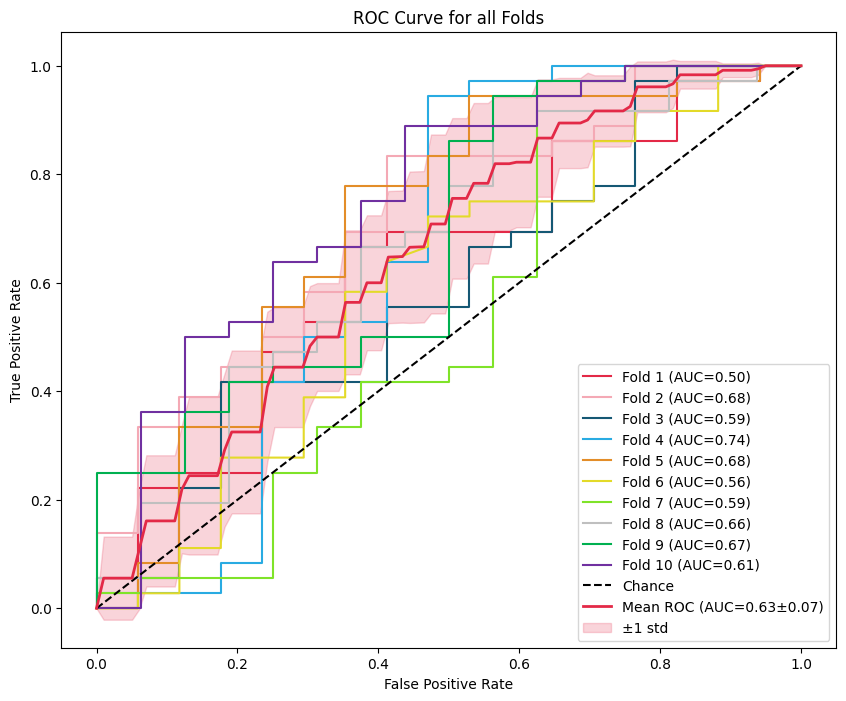

In [13]:
plt.figure(figsize=(10, 8))

# Custom color palette
colors = [
    "#E32947",  # red
    "#F4A9B5",  # pink
    "#155874",  # dark blue
    "#29ABE2",  # light blue
    "#E38D29",  # orange
    "#E3DA29",  # yellow
    "#7FE329",  # green (flashy)
    "#BFBFBF",  # grey
    "#00B050",  # green (basic)
    "#7030A0",  # purple
    "#996633",  # brown
]
# Repeat colors if more folds than colors
while len(colors) < len(fpr_list_all_folds):
    colors += colors

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i in range(len(fpr_list_all_folds)):
    interp_tpr = np.interp(mean_fpr, fpr_list_all_folds[i], tpr_list_all_folds[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    auc_val = auc_score_list_all_folds[i] if i < len(auc_score_list_all_folds) else None
    aucs.append(auc_val)
    plt.plot(
        fpr_list_all_folds[i],
        tpr_list_all_folds[i],
        color=colors[i],
        label=f'Fold {i+1} (AUC={auc_val:.2f})'
    )

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')

# Mean and std curves
tprs = np.array(tprs)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="#E32947",
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})',
    linewidth=2
)
plt.fill_between(
    mean_fpr,
    mean_tpr - std_tpr,
    mean_tpr + std_tpr,
    color="#E32947",
    alpha=0.2,
    label='±1 std'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc='lower right')
plt.show()

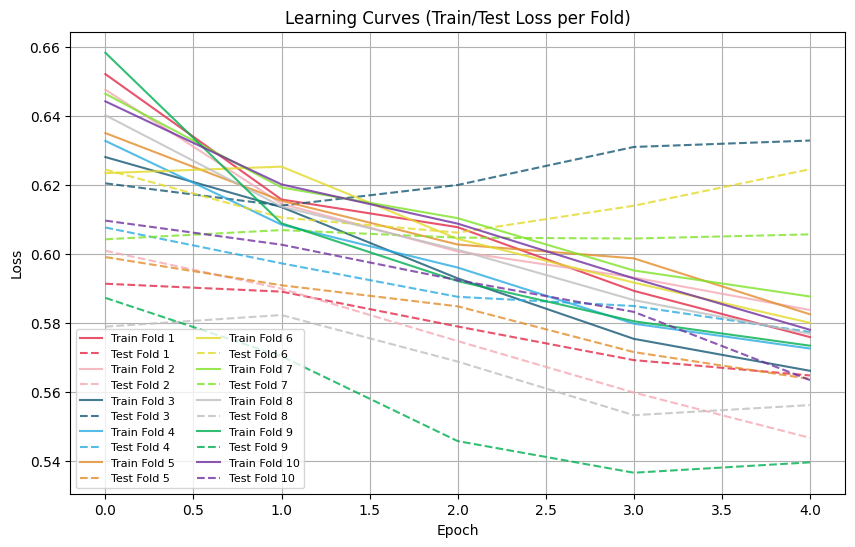

In [14]:
# Plot learning curves (train and test loss per epoch for each fold)
plt.figure(figsize=(10, 6))

for i in range(len(train_loss_all_folds)):
    plt.plot(train_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, label=f'Train Fold {i+1}')
    plt.plot(test_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, linestyle='--', label=f'Test Fold {i+1}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Train/Test Loss per Fold)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

In [15]:
print(f"Accuracy: {accuracy_list_all_folds}")
print(f"Accuracy Train: {accuracy_list_all_folds_train}")
print(f"F1 Score: {f1_list_all_folds}")
print(f"F1 Score Train: {f1_list_all_folds_train}")
print(f"Sensitivity: {sensitivity_list_all_folds}")
print(f"Sensitivity Train: {sensitivity_list_all_folds_train}")
print(f"Specificity: {specificity_list_all_folds}")
print(f"Specificity Train: {specificity_list_all_folds_train}")
print(f"AUC: {auc_score_list_all_folds}")
print(f"AUC Train: {auc_score_list_all_folds_train}")
print(f"Test Loss: {test_loss_max}")
print(f"Train Loss: {train_loss_max}")
print(f"Epochs: {epochs_all_fold}")

Accuracy: [67.9245283018868, 73.58490566037736, 73.58490566037736, 81.13207547169812, 77.35849056603774, 71.69811320754717, 75.0, 75.0, 78.84615384615384, 75.0]
Accuracy Train: [47.14587737843552, 73.15010570824523, 69.13319238900634, 71.03594080338267, 73.57293868921776, 68.49894291754757, 70.042194092827, 71.51898734177216, 70.25316455696202, 72.15189873417721]
F1 Score: [0.8089887640449438, 0.8108108108108109, 0.8372093023255814, 0.8717948717948718, 0.85, 0.8275862068965517, 0.8470588235294118, 0.8311688311688312, 0.8641975308641975, 0.8433734939759037]
F1 Score Train: [0.5519713261648745, 0.8276797829036635, 0.8151898734177215, 0.8011611030478955, 0.8331108144192256, 0.8130489335006273, 0.8193384223918575, 0.8068669527896996, 0.8189987163029525, 0.8235294117647058]
Sensitivity: [np.float64(1.0), np.float64(0.8333333333333334), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.9444444444444444), np.float64(1.0), np.float64(1.0), np.float64(0.8888888888888888), np.float64

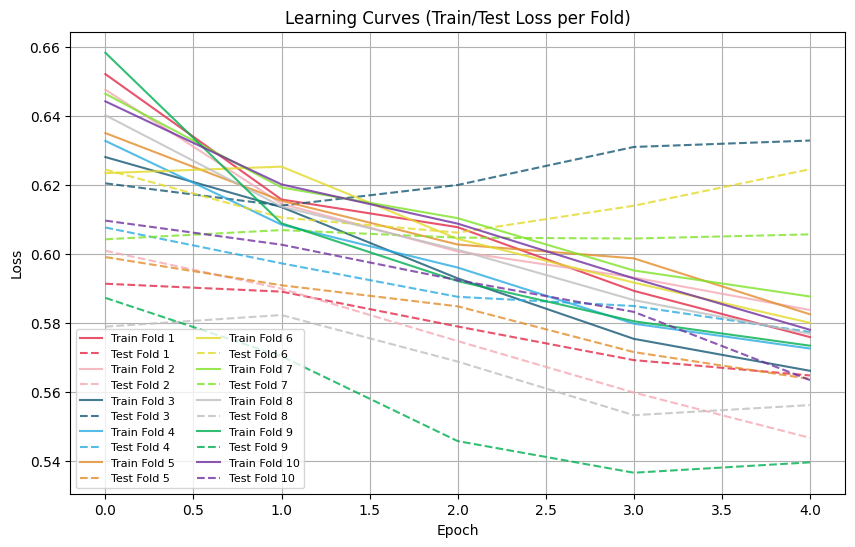

In [16]:
# Plot learning curves (train and test loss per epoch for each fold)
plt.figure(figsize=(10, 6))



for i in range(len(train_loss_all_folds)):
    plt.plot(train_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, label=f'Train Fold {i+1}')
    plt.plot(test_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, linestyle='--', label=f'Test Fold {i+1}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Train/Test Loss per Fold)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

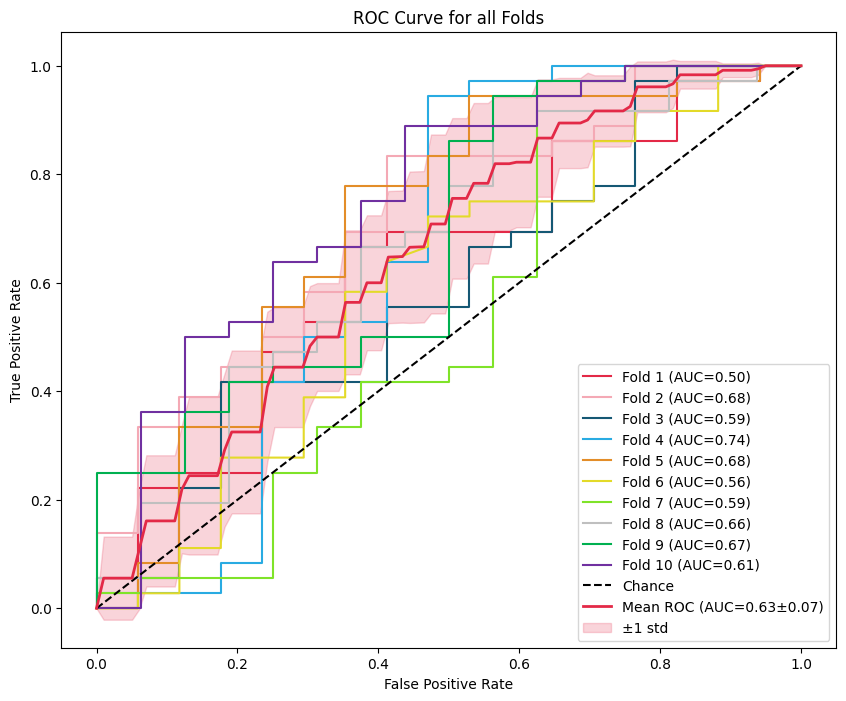

In [18]:
plt.figure(figsize=(10, 8))

# Custom color palette
colors = [
    "#E32947",  # red
    "#F4A9B5",  # pink
    "#155874",  # dark blue
    "#29ABE2",  # light blue
    "#E38D29",  # orange
    "#E3DA29",  # yellow
    "#7FE329",  # green (flashy)
    "#BFBFBF",  # grey
    "#00B050",  # green (basic)
    "#7030A0",  # purple
    "#996633",  # brown
]
# Repeat colors if more folds than colors
while len(colors) < len(fpr_list_all_folds):
    colors += colors

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i in range(len(fpr_list_all_folds)):
    interp_tpr = np.interp(mean_fpr, fpr_list_all_folds[i], tpr_list_all_folds[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    auc_val = auc_score_list_all_folds[i] if i < len(auc_score_list_all_folds) else None
    aucs.append(auc_val)
    plt.plot(
        fpr_list_all_folds[i],
        tpr_list_all_folds[i],
        color=colors[i],
        label=f'Fold {i+1} (AUC={auc_val:.2f})'
    )

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')

# Mean and std curves
tprs = np.array(tprs)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="#E32947",
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})',
    linewidth=2
)
plt.fill_between(
    mean_fpr,
    mean_tpr - std_tpr,
    mean_tpr + std_tpr,
    color="#E32947",
    alpha=0.2,
    label='±1 std'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc='lower right')
plt.show()